In [5]:
# Load the final processed dataset
import os
import pandas as pd
FIGURE_PATH = "../Figures/"

DATA_PATH = "../Dataset/neo_processed.csv"
df_processed = pd.read_csv(DATA_PATH)
print("Loaded shape:", df_processed.shape)
df_processed.head()

Loaded shape: (39709, 45)


,sats,H,diameter,albedo,rot_per,epoch,e,a,q,i,...,rms,diameter_estimated_flag,epoch_cal,class,hazardous_label,risk_score,perihelion_ratio,eccentric_energy,uncertainty_total,observation_span_years
0,0.0,10.39,16.840000,0.250,5.270,2461000.5,0.222836,1.458121,1.133199,10.828467,...,0.29796,0.0,2025-11-21.0000000,AMO,0,0.648766,0.777164,0.072404,1.179775e-06,127.621918
1,0.0,15.59,2.736306,0.137,5.801,2461000.5,0.546596,2.636590,1.195441,11.573111,...,0.40589,1.0,2025-11-21.0000000,AMO,0,0.318619,0.453404,0.787726,4.594650e-06,113.558904
2,0.0,13.81,4.200000,0.310,28.410,2461000.5,0.571170,2.473629,1.060766,9.400060,...,0.25971,0.0,2025-11-21.0000000,AMO,0,0.908811,0.428830,0.806985,1.123263e-06,107.619178
3,0.0,9.18,37.675000,0.238,10.297,2461000.5,0.533213,2.664969,1.243972,26.680736,...,0.31447,0.0,2025-11-21.0000000,AMO,0,0.317274,0.466787,0.757694,4.382260e-07,101.046575
4,0.0,17.37,1.000000,0.137,4.400,2461000.5,0.434632,1.919831,1.085411,11.868823,...,0.40562,0.0,2025-11-21.0000000,AMO,0,0.533213,0.565368,0.362666,7.272382e-06,93.005479


In [6]:
# Check target column exists and print alternatives if not
possible_targets = ['hazardous_label', 'hazardous', 'is_hazardous', 'pha']
for t in possible_targets:
    if t in df_processed.columns:
        print(f"Found candidate target column: {t}")

# Choose hazardous_label if present, otherwise pick the first candidate found
if 'hazardous_label' in df_processed.columns:
    target_col = 'hazardous_label'
else:
    found = [c for c in possible_targets if c in df_processed.columns]
    if found:
        target_col = found[0]
        print(f"Using alternative target column: {target_col}")
    else:
        print("Available columns:\n", df_processed.columns.tolist())
        raise SystemExit("No target column found. Please ensure the processed dataset contains the target column.")

print(f"Target column selected: {target_col}")

Found candidate target column: hazardous_label
Target column selected: hazardous_label


In [7]:
# Prepare features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

# Drop any original/duplicate label columns if present
for c in ['pha', 'hazardous', 'is_hazardous']:
    if c in X.columns:
        X = X.drop(columns=[c])

# Fill numeric NaNs with median (safety)
num_cols = X.select_dtypes(include=['number']).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# One-hot encode categorical features (if any)
X = pd.get_dummies(X, drop_first=True)

print("Feature matrix shape after preprocessing:", X.shape)
print("Sample columns:", X.columns[:20].tolist())

Feature matrix shape after preprocessing: (39709, 4169)
Sample columns: ['sats', 'H', 'diameter', 'albedo', 'rot_per', 'epoch', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'ad', 'n', 'per', 'per_y', 'moid', 'moid_ld', 'moid_jup']


In [8]:
X.columns

Index(['sats', 'H', 'diameter', 'albedo', 'rot_per', 'epoch', 'e', 'a', 'q',
       'i',
       ...
       'epoch_cal_2025-10-16.0000000', 'epoch_cal_2025-10-17.0000000',
       'epoch_cal_2025-10-18.0000000', 'epoch_cal_2025-10-19.0000000',
       'epoch_cal_2025-10-20.0000000', 'epoch_cal_2025-10-21.0000000',
       'epoch_cal_2025-11-21.0000000', 'class_APO', 'class_ATE', 'class_IEO'],
      dtype='object', length=4169)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import numpy as np

# -------------------------------
# 1. Scale the features
# -------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix shape:", X_scaled.shape)

# -------------------------------
# 2. Fit Isolation Forest
# -------------------------------
iso = IsolationForest(
    n_estimators=400,
    contamination=0.05,   # 5% anomalies
    max_features=1.0,
    random_state=42,
    n_jobs=-1
)

iso.fit(X_scaled)

# -------------------------------
# 3. Get anomaly scores & flags
# -------------------------------
scores = -iso.score_samples(X_scaled)   # higher = more anomalous
flags  = (iso.predict(X_scaled) == -1).astype(int)

df_processed["iso_score"] = scores
df_processed["iso_anomaly"] = flags

print("\nAnomaly counts:")
print(df_processed["iso_anomaly"].value_counts())

# -------------------------------
# 4. Compare Isolation Forest to NASA PHA ground truth
# -------------------------------
ct = pd.crosstab(df_processed["iso_anomaly"], df_processed[target_col])
print("\n--- Isolation Forest vs NASA PHA ---")
print(ct)

precision = ct.loc[1,1] / ct.loc[1].sum()
print(f"\n% of Isolation Forest anomalies that are NASA-PHAs: {precision:.4f}")

# -------------------------------
# 5. Show Top 50 Highest-Risk Objects
# -------------------------------
top_50 = df_processed.sort_values("iso_score", ascending=False).head(50)
print("\nTop 50 highest-risk anomaly candidates:")
print(top_50[["iso_score", "moid", "H", "diameter", target_col]].head(50))


Scaled feature matrix shape: (39709, 4169)

Anomaly counts:
iso_anomaly
0    37723
1     1986
Name: count, dtype: int64

--- Isolation Forest vs NASA PHA ---
hazardous_label      0     1
iso_anomaly                 
0                35468  2255
1                 1727   259

% of Isolation Forest anomalies that are NASA-PHAs: 0.1304

Top 50 highest-risk anomaly candidates:
       iso_score      moid       H  diameter  hazardous_label
11355   0.587548  0.597667  21.180  0.208528                0
11403   0.582835  0.466166  22.700  0.103553                0
11478   0.581558  0.332364  18.020  0.893644                0
15777   0.574469  0.068689  20.014  0.356751                0
8444    0.571293  0.162421  23.510  0.071312                0
7655    0.569537  0.342255  16.590  3.001000                0
6743    0.565717  0.109410  24.115  0.053972                0
7619    0.551496  0.257732  24.000  1.572000                0
6204    0.548571  0.093795  23.900  0.059589                0
17065

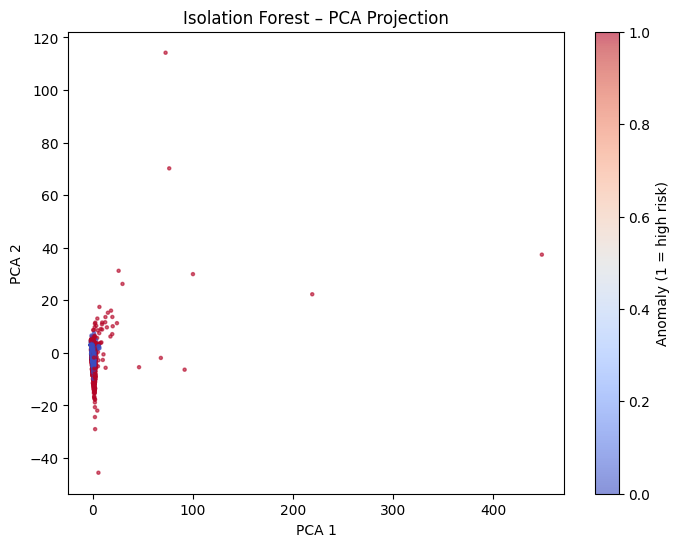

In [10]:
import matplotlib.pyplot as plt

# --------------------------------
# 6. PCA (2 components) for plotting
# --------------------------------
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)

df_processed["pca1"] = pca_coords[:, 0]
df_processed["pca2"] = pca_coords[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(
    df_processed["pca1"],
    df_processed["pca2"],
    c=df_processed["iso_anomaly"],
    cmap="coolwarm",
    s=5,
    alpha=0.6,
)
plt.title("Isolation Forest – PCA Projection")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Anomaly (1 = high risk)")
plt.show()


c:\Users\mail2\Desktop\Boston\Sem 1\CS 506 DS\Project\CS506_Project\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\mail2\Desktop\Boston\Sem 1\CS 506 DS\Project\CS506_Project\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Users\mail2\Desktop\Boston\Sem 1\CS 506 DS\Project\CS506_Project\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
 


LOF anomaly counts:
lof_anomaly
0    37723
1     1986
Name: count, dtype: int64

--- LOF vs NASA PHA ---
hazardous_label      0     1
lof_anomaly                 
0                35247  2476
1                 1948    38
% of LOF anomalies that are NASA-PHAs: 0.0191

Top 50 LOF anomaly candidates:
        lof_score      moid      H  diameter  hazardous_label
8069   156.801860  0.028508  26.30  0.019732                0
24385  156.199050  0.009884  26.74  0.016113                0
11982  155.070983  0.031664  26.10  0.021635                0
30802  154.855528  0.017917  25.76  0.025303                0
4108   154.799887  0.032271  26.00  0.022655                0
5609   153.931882  0.012698  25.70  0.026011                0
13374  153.407589  0.013461  27.50  0.011354                0
24107  152.346408  0.004054  26.80  0.015673                0
27793  152.113061  0.012578  25.39  0.030003                0
21975  151.776218  0.009869  27.20  0.013037                0
10499  151.772763 

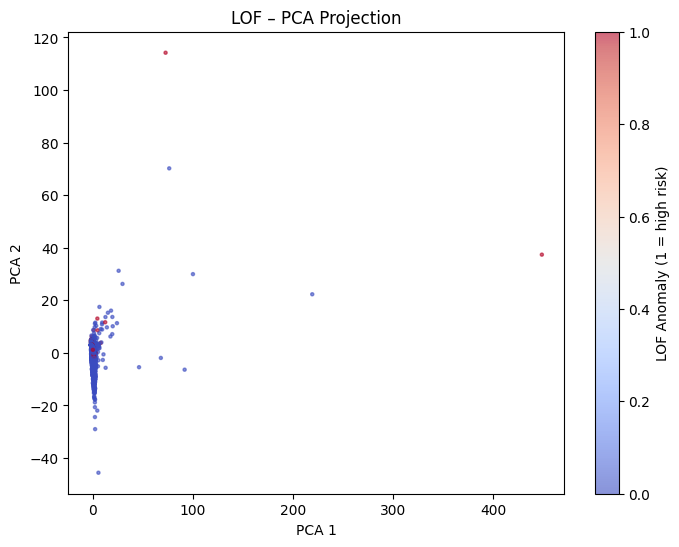

In [11]:
from sklearn.neighbors import LocalOutlierFactor

# -------------------------------
# LOF Model
# -------------------------------
lof = LocalOutlierFactor(
    n_neighbors=40,
    contamination=0.05,
    novelty=False  # standard LOF mode
)

lof_labels = lof.fit_predict(X_scaled)

# Convert LOF output: -1 = anomaly
df_processed["lof_anomaly"] = (lof_labels == -1).astype(int)

# Use negative outlier factor as score (lower = more abnormal)
df_processed["lof_score"] = -lof.negative_outlier_factor_

print("\nLOF anomaly counts:")
print(df_processed["lof_anomaly"].value_counts())

# --------------------------------------
# Compare with NASA PHA Truth Labels
# --------------------------------------
ct = pd.crosstab(df_processed["lof_anomaly"], df_processed[target_col])
print("\n--- LOF vs NASA PHA ---")
print(ct)

precision = ct.loc[1,1] / ct.loc[1].sum()
print(f"% of LOF anomalies that are NASA-PHAs: {precision:.4f}")

# --------------------------------------
# Top 50 highest risk
# --------------------------------------
lof_top50 = df_processed.sort_values("lof_score", ascending=False).head(50)
print("\nTop 50 LOF anomaly candidates:")
print(lof_top50[["lof_score", "moid", "H", "diameter", target_col]].head(50))

# --------------------------------------
# PCA Plot (colored by LOF anomaly)
# --------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(
    df_processed["pca1"],
    df_processed["pca2"],
    c=df_processed["lof_anomaly"],
    cmap="coolwarm",
    s=5,
    alpha=0.6
)
plt.title("LOF – PCA Projection")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="LOF Anomaly (1 = high risk)")
plt.show()


In [12]:
leaky = []
for col in X.columns:
    matches = (X[col] == y).sum()
    if matches > 0.5 * len(X):   # column matches target more than half the dataset
        leaky.append(col)

print("Leaky columns:", leaky)
X_clean = X.drop(columns=leaky)

Leaky columns: ['sats', 'epoch_cal_1990-10-27.0000000', 'epoch_cal_1991-01-18.0000000', 'epoch_cal_1991-05-12.0000000', 'epoch_cal_1991-10-07.0000000', 'epoch_cal_1991-10-08.0000000', 'epoch_cal_1991-11-05.0000000', 'epoch_cal_1991-12-07.0000000', 'epoch_cal_1992-02-28.0000000', 'epoch_cal_1992-12-27.0000000', 'epoch_cal_1993-01-29.0000000', 'epoch_cal_1993-03-30.0000000', 'epoch_cal_1993-04-27.0000000', 'epoch_cal_1993-05-22.0000000', 'epoch_cal_1994-03-12.0000000', 'epoch_cal_1994-03-15.0000000', 'epoch_cal_1994-03-17.0000000', 'epoch_cal_1994-04-09.0000000', 'epoch_cal_1994-07-07.0000000', 'epoch_cal_1994-09-02.0000000', 'epoch_cal_1994-10-12.0000000', 'epoch_cal_1994-11-01.0000000', 'epoch_cal_1994-11-04.0000000', 'epoch_cal_1994-12-09.0000000', 'epoch_cal_1995-02-03.0000000', 'epoch_cal_1995-02-06.0000000', 'epoch_cal_1995-02-28.0000000', 'epoch_cal_1995-03-30.0000000', 'epoch_cal_1995-07-06.0000000', 'epoch_cal_1996-01-17.0000000', 'epoch_cal_1996-01-23.0000000', 'epoch_cal_1996-

In [13]:
X_sup =  X_clean.drop(columns=["epoch_cal_2025-11-21.0000000","class_APO","risk_score"])
print(X_sup.columns)

Index(['H', 'diameter', 'albedo', 'rot_per', 'epoch', 'e', 'a', 'q', 'i', 'om',
       'w', 'ma', 'ad', 'n', 'per', 'per_y', 'moid', 'moid_ld', 'moid_jup',
       't_jup', 'sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om',
       'sigma_w', 'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per',
       'data_arc', 'n_obs_used', 'condition_code', 'rms',
       'diameter_estimated_flag', 'perihelion_ratio', 'eccentric_energy',
       'uncertainty_total', 'observation_span_years'],
      dtype='object')


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_Scaled2 = scaler.fit_transform(X_sup)


In [16]:

# -------------------------------
# 2. Fit Isolation Forest
# -------------------------------
iso = IsolationForest(
    n_estimators=4000,
    contamination=0.05,   # 5% anomalies
    max_features=1.0,
    random_state=42,
    n_jobs=-1
)

iso.fit(X_Scaled2)

# -------------------------------
# 3. Get anomaly scores & flags
# -------------------------------
scores = -iso.score_samples(X_Scaled2)   # higher = more anomalous
flags  = (iso.predict(X_Scaled2) == -1).astype(int)

df_processed["iso_score"] = scores
df_processed["iso_anomaly"] = flags

print("\nAnomaly counts:")
print(df_processed["iso_anomaly"].value_counts())

# -------------------------------
# 4. Compare Isolation Forest to NASA PHA ground truth
# -------------------------------
ct = pd.crosstab(df_processed["iso_anomaly"], df_processed[target_col])
print("\n--- Isolation Forest vs NASA PHA ---")
print(ct)

precision = ct.loc[1,1] / ct.loc[1].sum()
print(f"\n% of Isolation Forest anomalies that are NASA-PHAs: {precision:.4f}")

# -------------------------------
# 5. Show Top 50 Highest-Risk Objects
# -------------------------------
top_50 = df_processed.sort_values("iso_score", ascending=False).head(50)
print("\nTop 50 highest-risk anomaly candidates:")
print(top_50[["iso_score", "moid", "H", "diameter", target_col]].head(50))



Anomaly counts:
iso_anomaly
0    37723
1     1986
Name: count, dtype: int64

--- Isolation Forest vs NASA PHA ---
hazardous_label      0     1
iso_anomaly                 
0                35414  2309
1                 1781   205

% of Isolation Forest anomalies that are NASA-PHAs: 0.1032

Top 50 highest-risk anomaly candidates:
       iso_score      moid       H  diameter  hazardous_label
11355   0.784576  0.597667  21.180  0.208528                0
11403   0.779263  0.466166  22.700  0.103553                0
7655    0.776685  0.342255  16.590  3.001000                0
11478   0.774766  0.332364  18.020  0.893644                0
6743    0.772254  0.109410  24.115  0.053972                0
15777   0.771364  0.068689  20.014  0.356751                0
8444    0.767817  0.162421  23.510  0.071312                0
7619    0.761085  0.257732  24.000  1.572000                0
7844    0.754090  0.169486  24.000  0.808000                0
17065   0.752549  0.244285  18.633  0.673852    


LOF anomaly counts:
lof_anomaly
0    37723
1     1986
Name: count, dtype: int64

--- LOF vs NASA PHA ---
hazardous_label      0     1
lof_anomaly                 
0                35428  2295
1                 1767   219
% of LOF anomalies that are NASA-PHAs: 0.1103

Top 50 LOF anomaly candidates:
       lof_score      moid       H   diameter  hazardous_label
17344  56.939629  0.338407  21.200   0.206616                0
15669  30.116676  0.614845  18.350   0.767653                0
34965  25.556311  0.572521  20.301   0.312583                0
20051  21.291321  0.106560  22.610   0.107936                0
3605   21.107080  0.000267  27.400   0.011890                0
6743   17.605739  0.109410  24.115   0.053972                0
8191   16.313006  0.088655  24.400   0.047333                0
20903  11.961141  0.257783  18.167   0.835150                0
7655   11.138591  0.342255  16.590   3.001000                0
8171    8.438356  0.007680  26.562   0.017489                0
674    

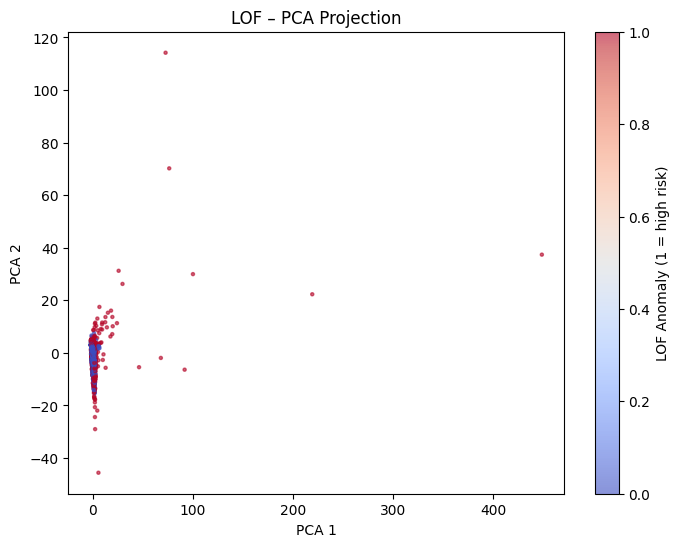

In [17]:
from sklearn.neighbors import LocalOutlierFactor

# -------------------------------
# LOF Model
# -------------------------------
lof = LocalOutlierFactor(
    n_neighbors=40,
    contamination=0.05,
    novelty=False  # standard LOF mode
)

lof_labels = lof.fit_predict(X_Scaled2)

# Convert LOF output: -1 = anomaly
df_processed["lof_anomaly"] = (lof_labels == -1).astype(int)

# Use negative outlier factor as score (lower = more abnormal)
df_processed["lof_score"] = -lof.negative_outlier_factor_

print("\nLOF anomaly counts:")
print(df_processed["lof_anomaly"].value_counts())

# --------------------------------------
# Compare with NASA PHA Truth Labels
# --------------------------------------
ct = pd.crosstab(df_processed["lof_anomaly"], df_processed[target_col])
print("\n--- LOF vs NASA PHA ---")
print(ct)

precision = ct.loc[1,1] / ct.loc[1].sum()
print(f"% of LOF anomalies that are NASA-PHAs: {precision:.4f}")

# --------------------------------------
# Top 50 highest risk
# --------------------------------------
lof_top50 = df_processed.sort_values("lof_score", ascending=False).head(50)
print("\nTop 50 LOF anomaly candidates:")
print(lof_top50[["lof_score", "moid", "H", "diameter", target_col]].head(50))

# --------------------------------------
# PCA Plot (colored by LOF anomaly)
# --------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(
    df_processed["pca1"],
    df_processed["pca2"],
    c=df_processed["lof_anomaly"],
    cmap="coolwarm",
    s=5,
    alpha=0.6
)
plt.title("LOF – PCA Projection")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="LOF Anomaly (1 = high risk)")
plt.show()
